# Baseline Model: Logistic Regression

## Import Libraries and Data Loading

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import numpy as np
import pandas as pd
from sklearn.metrics import log_loss, precision_score
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, Embedding, Dropout, Activation, LSTM, BatchNormalization, Bidirectional
from keras.layers.merge import concatenate
from keras.models import Model
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import callbacks, utils

import matplotlib.pyplot as plt
from keras.models import load_model

train_df_raw = pd.read_feather('../data/processed/x_train_dataset.feather')
val_df_raw = pd.read_feather('../data/processed/x_validation_dataset.feather')
test_df_raw = pd.read_feather('../data/processed/x_test_dataset.feather')
Embedding_File = '../data/processed/glove.840B.300d.txt'

In [3]:
train_df_raw.head(5)

,index,question1,question2,q1_start,q2_start,q1_topic,q2_topic,length_diff,same_question,lc_substring,...,q2_Problem/Increase,q2_Purpose/Energy,q2_Quora/Question/Google/Answer,q2_Relationship/Girl/Guy/People/Life,q2_Self-help/Learn/Business,q2_Sex/Woman/Man,q2_Social Media/Gadget/Email,q2_United States/Day,q2_Year/New/Stock/Company,is_duplicate
0,33525,Has Ancient Chaldea been scientifically tested?,Has Ancient History been scientifically tested...,ha,ha,Free/Ocatopm/Software/Website,Relationship/Girl/Guy/People/Life,-95,0,27,...,0,0,0,1,0,0,0,0,0,0
1,369925,What makes someone a good teacher?,What should be the first and most important qu...,what,what,Social Media/Gadget/Email,English/Law/Writing,-36,0,15,...,0,0,0,0,0,0,0,0,0,1
2,176858,Which is the best state for education for a in...,What is the best state in the U.S for internat...,which,what,Purpose/Energy,Job/College/University,13,0,22,...,0,0,0,0,0,0,0,0,0,1
3,293958,What are the most common ridge patterns in fin...,Which ridge pattern is the least common in fin...,what,which,Language/Relationship,Language/Relationship,0,0,16,...,0,0,0,0,0,0,0,0,0,0
4,182359,Social History: When did Americans start givin...,Today is my nephew 6th birthday. What is the b...,social,today,Self-help/Learn/Business,Job/College/University,-7,0,10,...,0,0,0,0,0,0,0,0,0,0


## Drop unneccessary columns

In [4]:
train_df = train_df_raw.drop(['index','q1_start','q2_start','q1_topic','q2_topic'],axis=1)
val_df = val_df_raw.drop(['index','q1_start','q2_start','q1_topic','q2_topic'],axis=1)
test_df = test_df_raw.drop(['index','q1_start','q2_start','q1_topic','q2_topic'],axis=1)
train_df.head(5)

,question1,question2,length_diff,same_question,lc_substring,lc_subsequence,jaccard_dist,common_words,common_ratio,levenshtein,...,q2_Problem/Increase,q2_Purpose/Energy,q2_Quora/Question/Google/Answer,q2_Relationship/Girl/Guy/People/Life,q2_Self-help/Learn/Business,q2_Sex/Woman/Man,q2_Social Media/Gadget/Email,q2_United States/Day,q2_Year/New/Stock/Company,is_duplicate
0,Has Ancient Chaldea been scientifically tested?,Has Ancient History been scientifically tested...,-95,0,27,39,0.219697,5,0.027473,0.428571,...,0,0,0,1,0,0,0,0,0,0
1,What makes someone a good teacher?,What should be the first and most important qu...,-36,0,15,27,0.148148,4,0.039604,0.534653,...,0,0,0,0,0,0,0,0,0,1
2,Which is the best state for education for a in...,What is the best state in the U.S for internat...,13,0,22,52,0.494382,9,0.060403,0.697987,...,0,0,0,0,0,0,0,0,0,1
3,What are the most common ridge patterns in fin...,Which ridge pattern is the least common in fin...,0,0,16,34,0.455882,6,0.056075,0.635514,...,0,0,0,0,0,0,0,0,0,0
4,Social History: When did Americans start givin...,Today is my nephew 6th birthday. What is the b...,-7,0,10,27,0.062500,2,0.015748,0.425197,...,0,0,0,0,0,0,0,0,0,0


## Build Word Embedding

In [5]:
Max_Sequence_Length = 60
Max_Num_Words = 200000 # There are about 300k+ unique words in the training set, 500k+ unique words in the entire dataset, 200,000 will be enough for tokenization
Embedding_Dim = 300

embeddings_index = {}
f = open(Embedding_File, encoding='utf-8')

for line in f:
    values = line.split()
    word = ''.join(values[:-300])   
    coefs = np.asarray(values[-300:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found {} word vectors of glove.'.format(len(embeddings_index)))


Found 2195892 word vectors of glove.


In [6]:
def text_to_wordlist(text, remove_stopwords=False): 
    text = text.lower().split()

    if remove_stopwords:
        stop_words = set(stopwords.words("english"))
        text = [w for w in text if not w in stop_words]
    
    text = " ".join(text)
    
    return(text)

In [7]:
train_q1 = train_df.question1.values
train_q2 = train_df.question2.values
train_labels = train_df['is_duplicate'].values

val_q1 = val_df.question1.values
val_q2 = val_df.question2.values
val_labels = val_df['is_duplicate'].values

test_q1 = test_df.question1.values
test_q2 = test_df.question2.values
test_labels = test_df['is_duplicate'].values

In [8]:
from nltk.corpus import stopwords
train_texts_1 = [] 
train_texts_2 = []
val_texts_1 = []
val_texts_2 = []
test_texts_1 = []
test_texts_2 = []

for text in train_q1:
    train_texts_1.append(text_to_wordlist(text, remove_stopwords=True))
    
for text in train_q2:
    train_texts_2.append(text_to_wordlist(text, remove_stopwords=True))
    
for text in val_q1:
    val_texts_1.append(text_to_wordlist(text, remove_stopwords=True))
    
for text in val_q2:
    val_texts_2.append(text_to_wordlist(text, remove_stopwords=True))
    
for text in test_q1:
    test_texts_1.append(text_to_wordlist(text, remove_stopwords=True))

for text in test_q2:
    test_texts_2.append(text_to_wordlist(text, remove_stopwords=True))

In [9]:
# Tokenize words in all sentences
tokenizer = Tokenizer(num_words=Max_Num_Words)
tokenizer.fit_on_texts(train_texts_1 + train_texts_2 +  val_texts_1 + val_texts_2 + test_texts_1 + test_texts_2)

train_sequences_1 = tokenizer.texts_to_sequences(train_texts_1)
train_sequences_2 = tokenizer.texts_to_sequences(train_texts_2)
val_sequences_1 = tokenizer.texts_to_sequences(val_texts_1)
val_sequences_2 = tokenizer.texts_to_sequences(val_texts_2)
test_sequences_1 = tokenizer.texts_to_sequences(test_texts_1)
test_sequences_2 = tokenizer.texts_to_sequences(test_texts_2)

word_index = tokenizer.word_index
print('{} unique tokens are found'.format(len(word_index)))

95589 unique tokens are found


In [10]:
from keras.preprocessing.sequence import pad_sequences
train_data_1 = pad_sequences(train_sequences_1, maxlen=Max_Sequence_Length)
train_data_2 = pad_sequences(train_sequences_2, maxlen=Max_Sequence_Length)
print('Shape of train data tensor:', train_data_1.shape)
print('Shape of train labels tensor:', train_labels.shape)

val_data_1 = pad_sequences(val_sequences_1, maxlen=Max_Sequence_Length)
val_data_2 = pad_sequences(val_sequences_2, maxlen=Max_Sequence_Length)
print('Shape of validation data tensor:', val_data_1.shape)
print('Shape of validation labels tensor:', val_labels.shape)

test_data_1 = pad_sequences(test_sequences_1, maxlen=Max_Sequence_Length)
test_data_2 = pad_sequences(test_sequences_2, maxlen=Max_Sequence_Length)
print('Shape of test data tensor:', test_data_2.shape)
print('Shape of test ids tensor:', test_labels.shape)

Shape of train data tensor: (323429, 60)
Shape of train labels tensor: (323429,)
Shape of validation data tensor: (40429, 60)
Shape of validation labels tensor: (40429,)
Shape of test data tensor: (40429, 60)
Shape of test ids tensor: (40429,)


### Preparing Numerical Features

In [30]:
with pd.option_context('display.max_columns',None):
    train_df.head(5)
add_feats = ['length_diff','lc_substring','lc_subsequence','jaccard_dist','common_words','common_ratio','levenshtein','fuzz_qratio','fuzz_wratio',
                     'question_mark_count_diff','freq_q1+q2','freq_q1-q2','dist_cosine','dist_euclidean']

train_feats1 = train_df[add_feats]
val_feats1 = val_df[add_feats]
test_feats1 = test_df[add_feats]

,question1,question2,length_diff,same_question,lc_substring,lc_subsequence,jaccard_dist,common_words,common_ratio,levenshtein,fuzz_qratio,fuzz_wratio,q2_question_mark_count,q1_question_mark_count,question_mark_count_diff,freq_q1+q2,freq_q1-q2,same_topic,same_starting,same_ending,wmdistance,dist_cosine,dist_cityblock,dist_canberra,dist_euclidean,dist_minkowski,q1_cleaned_v2,q2_cleaned_v2,q1_vector,q2_vector,q1_vec_0,q1_vec_1,q1_vec_2,q1_vec_3,q1_vec_4,q2_vec_0,q2_vec_1,q2_vec_2,q2_vec_3,q2_vec_4,q1_Assessment/Word/Home,q1_Best/Way/Visit,q1_Country/Car/Show/Television,q1_Engine/Password/Search,q1_English/Law/Writing,q1_Food/Health,q1_Free/Ocatopm/Software/Website,q1_India/Government/China,q1_Interview/Difference/Drug,q1_Job/College/University,q1_Language/Relationship,q1_Long/Review/Work/Compare,q1_Lose/Weight/Time/Travel/Salary,q1_Money/Bank/Online,q1_Movie/Video Game/Youtube,q1_Politics/Trump/Election,q1_Problem/Increase,q1_Purpose/Energy,q1_Quora/Question/Google/Answer,q1_Relationship/Girl/Guy/People/Life,q1_Self-help/Learn/Business,q1_Sex/Woman/Man,q1_Social Media/Gadget/Email,q1_United States/Day,q1_Year/New/Stock/Company,q2_Assessment/Word/Home,q2_Best/Way/Visit,q2_Country/Car/Show/Television,q2_Engine/Password/Search,q2_English/Law/Writing,q2_Food/Health,q2_Free/Ocatopm/Software/Website,q2_India/Government/China,q2_Interview/Difference/Drug,q2_Job/College/University,q2_Language/Relationship,q2_Long/Review/Work/Compare,q2_Lose/Weight/Time/Travel/Salary,q2_Money/Bank/Online,q2_Movie/Video Game/Youtube,q2_Politics/Trump/Election,q2_Problem/Increase,q2_Purpose/Energy,q2_Quora/Question/Google/Answer,q2_Relationship/Girl/Guy/People/Life,q2_Self-help/Learn/Business,q2_Sex/Woman/Man,q2_Social Media/Gadget/Email,q2_United States/Day,q2_Year/New/Stock/Company,is_duplicate,q_intersect,q1_freq,q2_freq
0,Has Ancient Chaldea been scientifically tested?,Has Ancient History been scientifically tested...,-95,0,27,39,0.219697,5,0.027473,0.428571,43,86,4,1,-3,11,-9,0,1,0,0.192389,0.238296,34.632359,167.718247,2.658521,2.658521,ha ancient chaldea scientifically tested,ha ancient history scientifically tested real ...,"[0.031408057, 0.10707768, 0.32202494, -0.23581...","[0.14967845, 0.2725273, -0.03749804, -0.142553...",0.031408,0.107078,0.322025,-0.235812,0.065765,0.149678,0.272527,-0.037498,-0.142554,0.114115,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,18
1,What makes someone a good teacher?,What should be the first and most important qu...,-36,0,15,27,0.148148,4,0.039604,0.534653,53,86,1,1,0,5,-3,0,1,1,0.343090,0.097663,24.251799,145.539053,1.837212,1.837212,make someone good teacher,first important quality good teacher,"[-0.005436562, 0.03173224, 0.027050504, 0.0323...","[0.008946306, 0.057755146, 0.05656157, 0.01483...",-0.005437,0.031732,0.027051,0.032324,0.018609,0.008946,0.057755,0.056562,0.014834,0.035993,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,4
2,Which is the best state for education for a in...,What is the best state in the U.S for internat...,13,0,22,52,0.494382,9,0.060403,0.697987,77,90,1,1,0,2,0,0,0,0,0.098867,0.015203,9.078124,89.634960,0.659214,0.659214,best state education international student uni...,best state united state international student,"[0.17608762, 0.09855839, 0.28985745, -0.232633...","[0.11724252, 0.14971006, 0.29985344, -0.303659...",0.176088,0.098558,0.289857,-0.232634,-0.038018,0.117243,0.149710,0.299853,-0.303660,-0.060581,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1
3,What are the most common ridge patterns in fin...,Which ridge pattern is the least common in fin...,0,0,16,34,0.455882,6,0.056075,0.635514,64,81,1,1,0,2,0,1,0,1,0.129774,0.039147,13.554628,110.654286,0.986643,0.986643,common ridge pattern fingerprint,ridge pattern least common fingerprint,"[0.25171572, -0.024394771, 0.11217328, -0.0639...","[0.29362243, 0.

In [31]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(np.vstack((train_feats1, val_feats1, test_feats1)))
train_feats1 = scaler.transform(train_feats1)
val_feats1 = scaler.transform(val_feats1)
test_feats1 = scaler.transform(test_feats1)

StandardScaler()

C:\Users\Calven\anaconda3\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\Calven\anaconda3\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\Calven\anaconda3\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


#### Building the Embedding Matrix for the embedding layer

In [47]:
num_words = min(Max_Num_Words, len(word_index))+1

embedding_matrix = np.zeros((num_words, Embedding_Dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

## Building the Bi-LSTM Model

1. We proceed to create the embedding layer with the embedding weights
2. Initialize the model
3. We will implement 1 dropout layer at 0.1 prob, and randomize the number of units between 100 to 150
4. Activation function will be relu for the input dense layers and sigmoid for the output layer
5. Finally, we compile it with nadam optimizer with Accuracy and Precision as the metrics.
6. Nadam was used over adam to the Nesterov momentum incorporation

We will keep the archictecture of the Bi-LSTM simple, with minimal layers and see how it performs in terms of both bias and variance then refine it later.

In [48]:
embedding_layer = Embedding(
    input_dim=num_words,
    output_dim=Embedding_Dim,
    weights=[embedding_matrix],
    input_length=Max_Sequence_Length,
    trainable=False
)    

In [49]:
bilstm_layer = Bidirectional(LSTM(64, return_sequences = False))

In [50]:
seq1 = Input(shape=(Max_Sequence_Length,), dtype='int32')
seq2 = Input(shape=(Max_Sequence_Length,), dtype='int32')

emb1 = embedding_layer(seq1)
emb2 = embedding_layer(seq2)

In [18]:
x1 = bilstm_layer(emb1)
x2 = bilstm_layer(emb2)

feats_input1 = Input(shape=(train_feats1.shape[1],))
feats_dense1 = Dense(int(np.random.randint(100, 150)/2), activation='relu')(feats_input1)

### Initial Model Building

In [20]:
combined = concatenate([x1, x2, feats_dense1])
combined = Dropout(0.1)(combined)

combined = Dense(np.random.randint(100, 150), activation='relu')(combined)

preds = Dense(1, activation='sigmoid')(combined)

In [21]:
model = Model(inputs=[seq1, seq2, feats_input1], outputs=preds)
model.compile(loss='binary_crossentropy', 
              optimizer='nadam', 
              metrics=['Accuracy','Precision'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 60)]         0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 60)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 60, 300)      28677000    ['input_4[0][0]',                
                                                                  'input_5[0][0]']                
                                                                                                  
 input_6 (InputLayer)           [(None, 14)]         0           []                           

In [22]:
es = callbacks.EarlyStopping(
    monitor = 'val_loss', patience = 5, verbose = 1)

history = model.fit([train_data_1, train_data_2, train_feats1], train_labels,
        validation_data=([val_data_1, val_data_2, val_feats1], val_labels),
        epochs=50, batch_size=1024, shuffle=True,
           callbacks=[es])

Epoch 1/50
316/316 [==============================] - 446s 1s/step - loss: 0.4256 - Accuracy: 0.7827 - precision: 0.7202 - val_loss: 0.3768 - val_Accuracy: 0.8159 - val_precision: 0.7443
Epoch 2/50
316/316 [==============================] - 390s 1s/step - loss: 0.3710 - Accuracy: 0.8186 - precision: 0.7681 - val_loss: 0.3557 - val_Accuracy: 0.8266 - val_precision: 0.7924
Epoch 3/50
316/316 [==============================] - 335s 1s/step - loss: 0.3516 - Accuracy: 0.8301 - precision: 0.7837 - val_loss: 0.3492 - val_Accuracy: 0.8306 - val_precision: 0.8136
Epoch 4/50
316/316 [==============================] - 372s 1s/step - loss: 0.3369 - Accuracy: 0.8386 - precision: 0.7945 - val_loss: 0.3398 - val_Accuracy: 0.8360 - val_precision: 0.8143
Epoch 5/50
316/316 [==============================] - 364s 1s/step - loss: 0.3239 - Accuracy: 0.8461 - precision: 0.8043 - val_loss: 0.3343 - val_Accuracy: 0.8396 - val_precision: 0.8209
Epoch 6/50
316/316 [==============================] - 367s 1s/ste

## Predictions

In [23]:
model.save('model/Siamese_biLSTM.h5')

<AxesSubplot:>

Text(0.5, 1.0, 'Model Loss')

Text(0, 0.5, 'Loss')

Text(0.5, 0, 'Epoch')

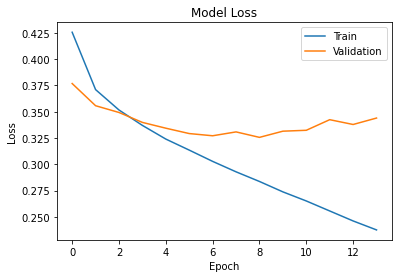

In [24]:
# Plot loss
plt.subplot()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

### We can seem from the plot, that there is a huge variance issue. Hence, here we...
 Solve Variance
- Perform regularization with more dropouts and earlier stopping
- Reduce units and increase learning rate slightly
- Add batch normalization, we understand that batch normalization provides some sort of reguarlization effects, and there is dedicated research papers in identifying the need of combining batch norm with drop out such as [Understanding the Disharmony between Dropout and Batch Normalization by Variance Shift](https://arxiv.org/pdf/1801.05134.pdf) and [Dropout as a Bayesian Approximation: Representing Model Uncertainty in Deep Learning](https://arxiv.org/abs/1506.02142). But due to the huge difference in train and val/test and our design, we decided to incorporate both after experiment them individually.

## Second Model Building
### Refining the LSTM

In [17]:
ques = pd.concat([train_df[['question1', 'question2']],
        val_df[['question1', 'question2']], test_df[['question1','question2']]], axis=0).reset_index(drop='index')
ques.shape

(404287, 2)

In [18]:
from collections import defaultdict
q_dict = defaultdict(set)
for i in range(ques.shape[0]):
        q_dict[ques.question1[i]].add(ques.question2[i])
        q_dict[ques.question2[i]].add(ques.question1[i])

def q_intersect(row):
    return(len(set(q_dict[row[0]]).intersection(set(q_dict[row[1]]))))

def q1_freq(row):
    return(len(q_dict[row[0]]))
    
def q2_freq(row):
    return(len(q_dict[row[1]]))

train_df['q_intersect'] = train_df.apply(q_intersect, axis=1, raw=True)
val_df['q_intersect'] = val_df.apply(q_intersect, axis=1, raw=True)
test_df['q_intersect'] = test_df.apply(q_intersect, axis=1, raw=True)

train_df['q1_freq'] = train_df.apply(q1_freq, axis=1, raw=True)
train_df['q2_freq'] = train_df.apply(q2_freq, axis=1, raw=True)

val_df['q1_freq'] = val_df.apply(q1_freq, axis=1, raw=True)
val_df['q2_freq'] = val_df.apply(q2_freq, axis=1, raw=True)

test_df['q1_freq'] = test_df.apply(q1_freq, axis=1, raw=True)
test_df['q2_freq'] = test_df.apply(q2_freq, axis=1, raw=True)

In [19]:
with pd.option_context('display.max_columns',None):
    train_df.head(5)
add_feats = ['q_intersect','q1_freq','q2_freq']

train_feats = train_df[add_feats]
val_feats = val_df[add_feats]
test_feats = test_df[add_feats]

,question1,question2,length_diff,same_question,lc_substring,lc_subsequence,jaccard_dist,common_words,common_ratio,levenshtein,fuzz_qratio,fuzz_wratio,q2_question_mark_count,q1_question_mark_count,question_mark_count_diff,freq_q1+q2,freq_q1-q2,same_topic,same_starting,same_ending,wmdistance,dist_cosine,dist_cityblock,dist_canberra,dist_euclidean,dist_minkowski,q1_cleaned_v2,q2_cleaned_v2,q1_vector,q2_vector,q1_vec_0,q1_vec_1,q1_vec_2,q1_vec_3,q1_vec_4,q2_vec_0,q2_vec_1,q2_vec_2,q2_vec_3,q2_vec_4,q1_Assessment/Word/Home,q1_Best/Way/Visit,q1_Country/Car/Show/Television,q1_Engine/Password/Search,q1_English/Law/Writing,q1_Food/Health,q1_Free/Ocatopm/Software/Website,q1_India/Government/China,q1_Interview/Difference/Drug,q1_Job/College/University,q1_Language/Relationship,q1_Long/Review/Work/Compare,q1_Lose/Weight/Time/Travel/Salary,q1_Money/Bank/Online,q1_Movie/Video Game/Youtube,q1_Politics/Trump/Election,q1_Problem/Increase,q1_Purpose/Energy,q1_Quora/Question/Google/Answer,q1_Relationship/Girl/Guy/People/Life,q1_Self-help/Learn/Business,q1_Sex/Woman/Man,q1_Social Media/Gadget/Email,q1_United States/Day,q1_Year/New/Stock/Company,q2_Assessment/Word/Home,q2_Best/Way/Visit,q2_Country/Car/Show/Television,q2_Engine/Password/Search,q2_English/Law/Writing,q2_Food/Health,q2_Free/Ocatopm/Software/Website,q2_India/Government/China,q2_Interview/Difference/Drug,q2_Job/College/University,q2_Language/Relationship,q2_Long/Review/Work/Compare,q2_Lose/Weight/Time/Travel/Salary,q2_Money/Bank/Online,q2_Movie/Video Game/Youtube,q2_Politics/Trump/Election,q2_Problem/Increase,q2_Purpose/Energy,q2_Quora/Question/Google/Answer,q2_Relationship/Girl/Guy/People/Life,q2_Self-help/Learn/Business,q2_Sex/Woman/Man,q2_Social Media/Gadget/Email,q2_United States/Day,q2_Year/New/Stock/Company,is_duplicate,q_intersect,q1_freq,q2_freq
0,Has Ancient Chaldea been scientifically tested?,Has Ancient History been scientifically tested...,-95,0,27,39,0.219697,5,0.027473,0.428571,43,86,4,1,-3,11,-9,0,1,0,0.192389,0.238296,34.632359,167.718247,2.658521,2.658521,ha ancient chaldea scientifically tested,ha ancient history scientifically tested real ...,"[0.031408057, 0.10707768, 0.32202494, -0.23581...","[0.14967845, 0.2725273, -0.03749804, -0.142553...",0.031408,0.107078,0.322025,-0.235812,0.065765,0.149678,0.272527,-0.037498,-0.142554,0.114115,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,18
1,What makes someone a good teacher?,What should be the first and most important qu...,-36,0,15,27,0.148148,4,0.039604,0.534653,53,86,1,1,0,5,-3,0,1,1,0.343090,0.097663,24.251799,145.539053,1.837212,1.837212,make someone good teacher,first important quality good teacher,"[-0.005436562, 0.03173224, 0.027050504, 0.0323...","[0.008946306, 0.057755146, 0.05656157, 0.01483...",-0.005437,0.031732,0.027051,0.032324,0.018609,0.008946,0.057755,0.056562,0.014834,0.035993,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,4
2,Which is the best state for education for a in...,What is the best state in the U.S for internat...,13,0,22,52,0.494382,9,0.060403,0.697987,77,90,1,1,0,2,0,0,0,0,0.098867,0.015203,9.078124,89.634960,0.659214,0.659214,best state education international student uni...,best state united state international student,"[0.17608762, 0.09855839, 0.28985745, -0.232633...","[0.11724252, 0.14971006, 0.29985344, -0.303659...",0.176088,0.098558,0.289857,-0.232634,-0.038018,0.117243,0.149710,0.299853,-0.303660,-0.060581,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1
3,What are the most common ridge patterns in fin...,Which ridge pattern is the least common in fin...,0,0,16,34,0.455882,6,0.056075,0.635514,64,81,1,1,0,2,0,1,0,1,0.129774,0.039147,13.554628,110.654286,0.986643,0.986643,common ridge pattern fingerprint,ridge pattern least common fingerprint,"[0.25171572, -0.024394771, 0.11217328, -0.0639...","[0.29362243, 0.

In [41]:
scaler = StandardScaler()
scaler.fit(np.vstack((train_feats, val_feats, test_feats)))
train_feats = scaler.transform(train_feats)
val_feats = scaler.transform(val_feats)
test_feats = scaler.transform(test_feats)

StandardScaler()

In [59]:
bilstm_layer2 = Bidirectional(LSTM(np.random.randint(50, 80), dropout=0.15, recurrent_dropout=0.15))

In [60]:
lstm_a = bilstm_layer2(emb1) #Same emb as model 1

lstm_b = bilstm_layer2(emb2)

In [61]:
feats_input = Input(shape=(train_feats.shape[1],))
feats_dense = Dense(int(np.random.randint(100, 150)/2), activation='relu')(feats_input)

In [62]:
combined_2 = concatenate([lstm_a , lstm_b, feats_dense])
combined_2 = BatchNormalization()(combined_2)
combined_2 = Dropout(0.2)(combined_2)

combined_2 = Dense(150, activation='relu')(combined_2)
combined_2 = BatchNormalization()(combined_2)
combined_2 = Dropout(0.2)(combined_2)

out_ = Dense(1, activation='sigmoid')(combined_2)

model2 = Model(inputs=[seq1, seq2, feats_input], outputs=out_)
model2.compile(loss='binary_crossentropy', 
              optimizer='nadam', 
              metrics=['Accuracy','Precision'])
model2.summary()
utils.plot_model(model2, show_shapes=True, expand_nested=True)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 60)]         0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 60)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 60, 300)      28677000    ['input_3[0][0]',                
                                                                  'input_4[0][0]']                
                                                                                                  
 input_7 (InputLayer)           [(None, 3)]          0           []                         

We examine the class label imbalances in the training set again.
Source code is from [tensorflow](https://www.tensorflow.org/tutorials/structured_data/imbalanced_data)

In [71]:
neg, pos = np.bincount(train_df_raw['is_duplicate'])

total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Examples:
    Total: 323429
    Positive: 119410 (36.92% of total)

Weight for class 0: 0.79
Weight for class 1: 1.35


In [63]:
weight_val = np.ones(len( val_labels))
weight_val *= 0.79
weight_val[val_labels==0] = 1.35
# Add class weight
class_weight = {0: 1.35, 1: 0.79}
                                                          
es = callbacks.EarlyStopping(
monitor = 'val_loss', patience = 8, verbose = 1)

history2 = model2.fit([train_data_1, train_data_2, train_feats], train_labels,
        validation_data=([val_data_1, val_data_2, val_feats], val_labels),
        epochs=200, batch_size=512, shuffle=True, class_weight=class_weight,
           callbacks=[es])

Epoch 1/200
632/632 [==============================] - 3204s 5s/step - loss: 0.2660 - Accuracy: 0.8323 - precision: 0.9400 - val_loss: 0.3499 - val_Accuracy: 0.8448 - val_precision: 0.9726
Epoch 2/200
632/632 [==============================] - 3256s 5s/step - loss: 0.2288 - Accuracy: 0.8433 - precision: 0.9671 - val_loss: 0.3132 - val_Accuracy: 0.8534 - val_precision: 0.9561
Epoch 3/200
632/632 [==============================] - 3296s 5s/step - loss: 0.2185 - Accuracy: 0.8462 - precision: 0.9681 - val_loss: 0.2954 - val_Accuracy: 0.8648 - val_precision: 0.9132
Epoch 4/200
632/632 [==============================] - 3431s 5s/step - loss: 0.2111 - Accuracy: 0.8494 - precision: 0.9691 - val_loss: 0.3101 - val_Accuracy: 0.8535 - val_precision: 0.9730
Epoch 5/200
632/632 [==============================] - 3402s 5s/step - loss: 0.2051 - Accuracy: 0.8522 - precision: 0.9704 - val_loss: 0.3574 - val_Accuracy: 0.8326 - val_precision: 0.9893
Epoch 6/200
632/632 [==============================] - 

In [64]:
model2.save('model/Siamese_LSTM.h5')

<AxesSubplot:>

Text(0.5, 1.0, 'Model Loss')

Text(0, 0.5, 'Loss')

Text(0.5, 0, 'Epoch')

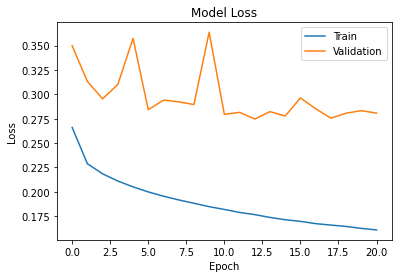

In [65]:
# Plot loss
plt.subplot()
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

## Make Predictions
- Take two predictions for each and average them

In [66]:
model1 = load_model('model/Siamese_biLSTM.h5')
model2 = load_model('model/Siamese_LSTM.h5')

In [67]:
preds_prob_train1 = model1.predict([train_data_1, train_data_2, train_feats1], batch_size=1024, verbose=1)
preds_prob_train1  += model1.predict([train_data_1, train_data_2, train_feats1], batch_size=1024, verbose=1)
preds_prob_train1 = preds_prob_train1  / 2

preds_prob_train2 = model2.predict([train_data_1, train_data_2, train_feats], batch_size=512, verbose=1)
preds_prob_train2 += model2.predict([train_data_1, train_data_2, train_feats], batch_size=512, verbose=1)
preds_prob_train2 = preds_prob_train2 / 2

632/632 [==============================] - 466s 737ms/step


In [68]:
preds_prob_test1 = model1.predict([test_data_1, test_data_2, test_feats1], batch_size=1024, verbose=1)
preds_prob_test1 += model1.predict([test_data_1, test_data_2, test_feats1], batch_size=1024, verbose=1)
preds_prob_test1 = preds_prob_test1 / 2

preds_prob_test2 = model2.predict([test_data_1, test_data_2, test_feats], batch_size=512, verbose=1)
preds_prob_test2 += model2.predict([test_data_1, test_data_2, test_feats], batch_size=512, verbose=1)
preds_prob_test2 = preds_prob_test2 / 2

79/79 [==============================] - 54s 681ms/step


In [69]:
preds_prob_train_final = (preds_prob_train1 + preds_prob_train2) / 2
preds_prob_test_final = (preds_prob_test1 + preds_prob_test2) / 2

preds_prob_train_final = 1 - preds_prob_train_final
preds_prob_test_final = 1 - preds_prob_test_final

In [70]:
np.savetxt("../data/processed/predictions_full_siamLSTM_train.csv", preds_prob_train_final, delimiter=",")
np.savetxt("../data/processed/predictions_full_siamLSTM_test.csv", preds_prob_test_final, delimiter=",")